In [9]:
sns.set_theme(style="whitegrid")
df = pd.read_csv('cleaned_data/TfL_2024_Cleaned_Data.csv')
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['Date'] = df['Start_Date'].dt.date
print("Data loaded successfully. Rows:", len(df))
display(df.head())

Data loaded successfully. Rows: 4559587


,Rental_Id,Start_Date,Start_Station_Id,Start_Station_Name,End_Date,End_Station_Id,End_Station_Name,Bike number,Bike model,Total duration,Duration_ms,Duration_Secs,Month,Hour,Day_of_Week,Year,Season,Is_Weekend,Date
0,145207080,2024-12-14 23:59:00,1133,"Baylis Road, Waterloo",2024-12-15 00:26:00,200011,"Furze Green, Bow",62625.0,PBSC_EBIKE,27m 0s,1620164,1620.164,12,23,5,2024,Winter,1,2024-12-14
1,145207081,2024-12-14 23:59:00,3447,"Gloucester Road (North), Kensington",2024-12-15 00:17:00,200181,"Richmond Way, Shepherd's Bush",62291.0,PBSC_EBIKE,18m 16s,1096981,1096.981,12,23,5,2024,Winter,1,2024-12-14
2,145207082,2024-12-14 23:59:00,1112,"Nutford Place, Marylebone",2024-12-15 00:12:00,3422,"Charlbert Street, St. John's Wood",50575.0,CLASSIC,13m 3s,783763,783.763,12,23,5,2024,Winter,1,2024-12-14
3,145207083,2024-12-14 23:59:00,1122,"Ashley Place, Victoria",2024-12-15 00:04:00,200048,"Page Street, Westminster",52143.0,CLASSIC,5m 22s,322155,322.155,12,23,5,2024,Winter,1,2024-12-14
4,145207084,2024-12-14 23:59:00,300207,"Gauden Road, Clapham",2024-12-15 00:06:00,300055,"Stewart's Road, Wandsworth Road",35590.0,CLASSIC,6m 55s,415930,415.930,12,23,5,2024,Winter,1,2024-12-14


In [ ]:
daily_data = df.groupby('Date').agg(
    Daily_Ride_Count=('Rental_Id', 'count'),    
    Is_Weekend=('Is_Weekend', 'max'),           
    Season=('Season', 'first')                  
).reset_index()

daily_data = pd.get_dummies(daily_data, columns=['Season'], drop_first=True)

bool_cols = daily_data.select_dtypes(include=['bool']).columns
daily_data[bool_cols] = daily_data[bool_cols].astype(int)

print("Daily aggregation complete. Data is ready for modeling.")
display(daily_data.head())

Daily aggregation complete. Data is ready for modeling.


,Date,Daily_Ride_Count,Is_Weekend,Season_Summer,Season_Winter
0,2024-07-01,27975,0,1,0
1,2024-07-02,29525,0,1,0
2,2024-07-03,28757,0,1,0
3,2024-07-04,32569,0,1,0
4,2024-07-05,15898,0,1,0


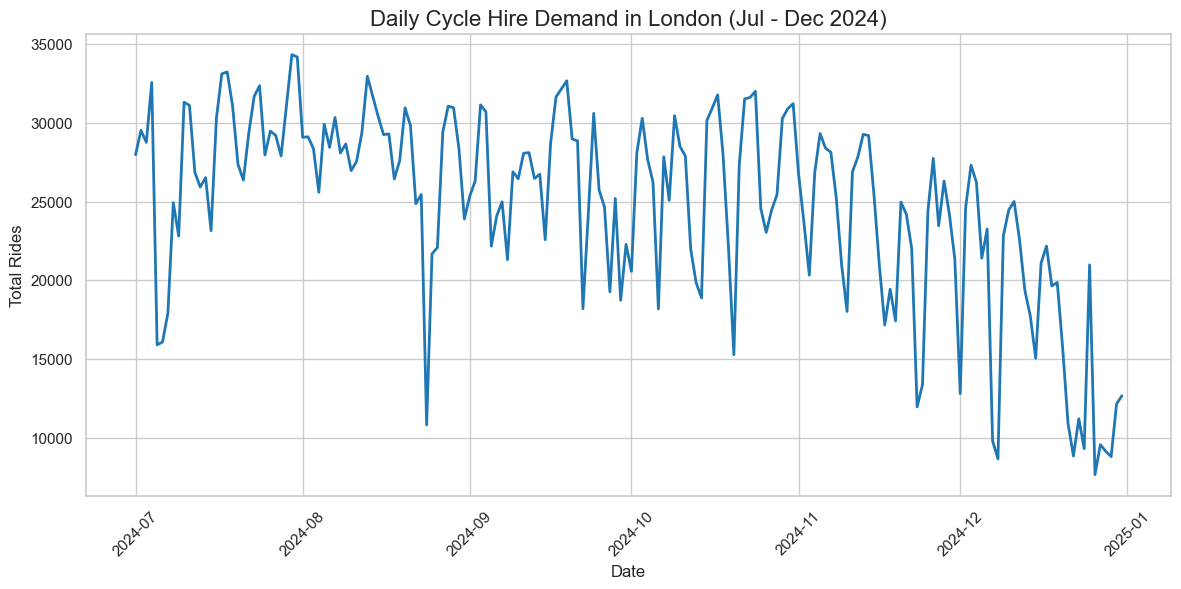

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_data, x='Date', y='Daily_Ride_Count', color='tab:blue', linewidth=2)

plt.title('Daily Cycle Hire Demand in London (Jul - Dec 2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Rides', fontsize=12)
plt.xticks(rotation=45)

plt.show()

In [ ]:
Y = daily_data['Daily_Ride_Count']
X_features = ['Is_Weekend'] + [col for col in daily_data.columns if 'Season_' in col]
X = daily_data[X_features]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Daily_Ride_Count   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     75.19
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           1.42e-31
Time:                        22:33:57   Log-Likelihood:                -1791.0
No. Observations:                 184   AIC:                             3590.
Df Residuals:                     180   BIC:                             3603.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.703e+04    474.007     57.032

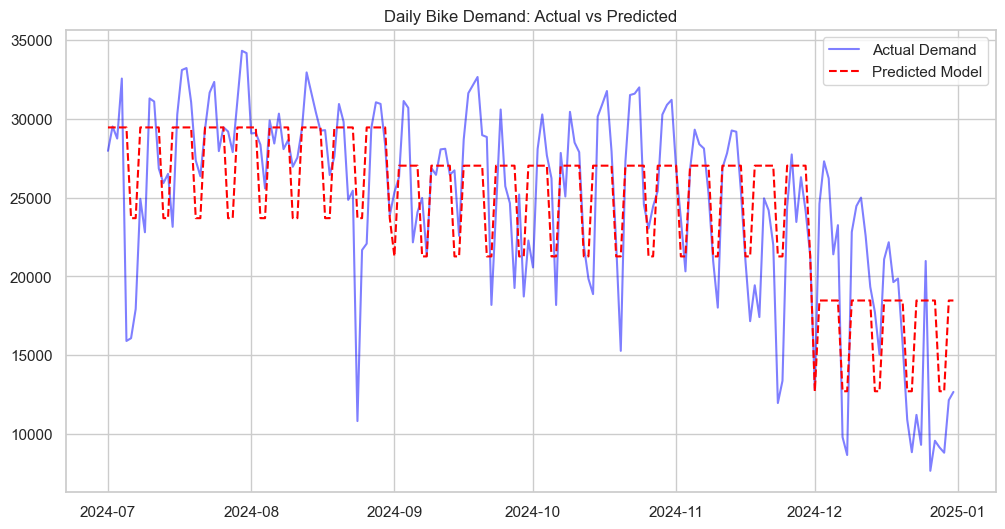

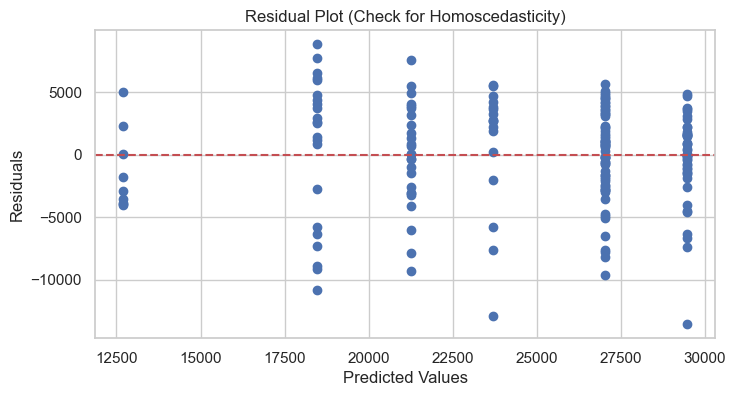

In [ ]:
daily_data['Predicted_Demand'] = model.predict(X)

# actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Daily_Ride_Count'], label='Actual Demand', color='blue', alpha=0.5)
plt.plot(daily_data['Date'], daily_data['Predicted_Demand'], label='Predicted Model', color='red', linestyle='--')
plt.title('Daily Bike Demand: Actual vs Predicted')
plt.legend()
plt.show()

# residual plot
residuals = model.resid
plt.figure(figsize=(8, 4))
plt.scatter(daily_data['Predicted_Demand'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot (Check for Homoscedasticity)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

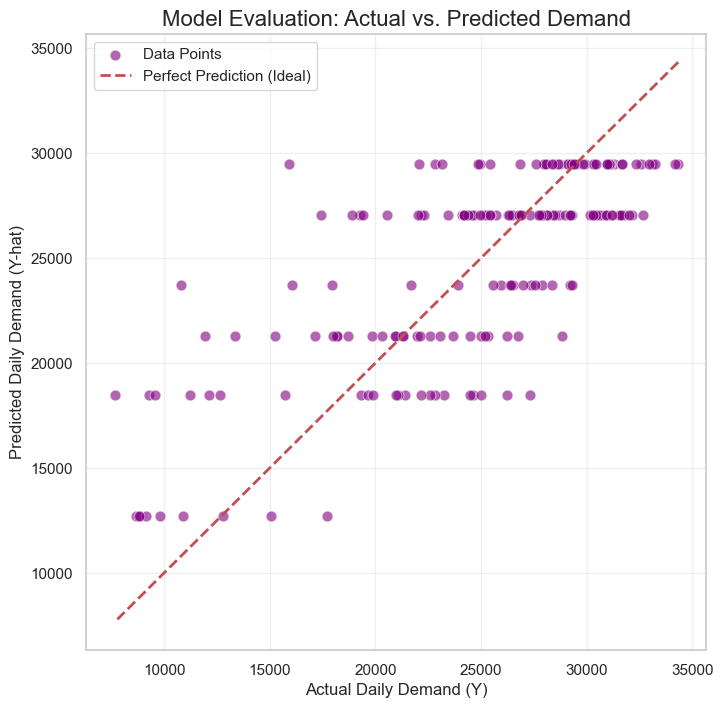

In [ ]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(x=daily_data['Daily_Ride_Count'], y=daily_data['Predicted_Demand'], 
                color='purple', alpha=0.6, s=60, label='Data Points')

p1 = max(max(daily_data['Predicted_Demand']), max(daily_data['Daily_Ride_Count']))
p2 = min(min(daily_data['Predicted_Demand']), min(daily_data['Daily_Ride_Count']))
plt.plot([p1, p2], [p1, p2], 'r--', linewidth=2, label='Perfect Prediction (Ideal)')

plt.title('Model Evaluation: Actual vs. Predicted Demand', fontsize=16)
plt.xlabel('Actual Daily Demand (Y)', fontsize=12)
plt.ylabel('Predicted Daily Demand (Y-hat)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Prepare Data for Tableau Dashboard
input_file = 'cleaned_data/TfL_2024_Cleaned_Data.csv'
print(f"Loading data from {input_file}...")
df = pd.read_csv(input_file)
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['Date'] = df['Start_Date'].dt.date

daily_data = df.groupby('Date').agg(
    Daily_Ride_Count=('Rental_Id', 'count'),  
    Is_Weekend=('Is_Weekend', 'max'),        
    Season=('Season', 'first')        
).reset_index()

model_data = pd.get_dummies(daily_data, columns=['Season'], drop_first=True)

bool_cols = model_data.select_dtypes(include=['bool']).columns
model_data[bool_cols] = model_data[bool_cols].astype(int)

Y = model_data['Daily_Ride_Count']

features = ['Is_Weekend'] + [col for col in model_data.columns if 'Season_' in col]
X = model_data[features]

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print("\n--- Model Summary ---")
print(model.summary())

daily_data['Predicted_Demand'] = model.predict(X)

daily_data['Residuals'] = daily_data['Daily_Ride_Count'] - daily_data['Predicted_Demand']

output_file = 'cleaned_data/Tableau_Model_Results.csv'
daily_data.to_csv(output_file, index=False)

print(f"\nSUCCESS: Model results exported to: {output_file}")
print("You can now import this file into Tableau to create Actual vs. Predicted charts.")

Loading data from cleaned_data/TfL_2024_Cleaned_Data.csv...

--- Model Summary ---
                            OLS Regression Results                            
Dep. Variable:       Daily_Ride_Count   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     75.19
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           1.42e-31
Time:                        00:14:31   Log-Likelihood:                -1791.0
No. Observations:                 184   AIC:                             3590.
Df Residuals:                     180   BIC:                             3603.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------